# Yelp Affluence Cluster Model - K-Means 1/14/19
### Britt Allen, Bernard Kurka, Tom Ludlow

In [12]:
%matplotlib inline

from sklearn.cluster import KMeans, k_means
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
#Reading files
yelp = pd.read_csv('../Data/yelp_nyc_total.csv',dtype={'zip': 'str'})
irs = pd.read_csv('../final_irs_data.csv',dtype={'zipcode': 'str'})

#building a final df with irs + yelp 
irs = irs[['zipcode','affluence']]
#joining data frames
data = yelp.merge(irs, how='left', left_on='zip', right_on='zipcode')
#dop
data.drop('zipcode',axis=1,inplace=True)

In [61]:
data.head()

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,pr_4,rv_4,avg_lat,avg_long,affluence
0,10001,New York,NY,none,8,9740,28,29095,4,5507,0,0,40.747709,-73.990216,163.503168
1,10002,New York,NY,none,18,15201,39,43425,4,4740,0,0,40.719057,-73.989387,56.616311
2,10003,New York,NY,none,16,19139,54,91952,6,8836,3,5125,40.730866,-73.988554,239.728018
3,10004,New York,NY,none,12,1980,26,10361,6,2128,2,1153,40.704432,-74.011839,340.068952
4,10005,New York,NY,none,7,1425,11,2268,1,89,1,177,40.706222,-74.008576,543.720875


In [62]:
data.shape

(210, 15)

In [14]:
data['pr_2m'] = data['pr_2'] * 2
data['pr_3m'] = data['pr_3'] * 3
data['pr_4m'] = data['pr_4'] * 4

In [15]:
data['pr_tot'] = data['pr_1'] + data['pr_2'] + data['pr_3'] + data['pr_4']
data['rv_tot'] = data['rv_1'] + data['rv_2'] + data['rv_3'] + data['rv_4']
data['pr_totm'] = data['pr_1'] + data['pr_2m'] + data['pr_3m'] + data['pr_4m']

In [16]:
ss = StandardScaler()

In [17]:
features = ['pr_1','rv_1','pr_2','pr_2m','rv_2',
            'pr_3','pr_3m','rv_3','pr_4','pr_4m',
            'rv_4','pr_tot','rv_tot','pr_totm'] #,'avg_lat','avg_long']


In [18]:
data_feat_ss = ss.fit_transform(data[features])

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [19]:
ss_feat = ['pr_1s','rv_1s','pr_2s','pr_2ms','rv_2s',
           'pr_3s','pr_3ms','rv_3s','pr_4s','pr_4ms',
           'rv_4s','pr_tots','rv_tots','pr_totms']


In [20]:
for col in ss_feat:
    data[col] = 0

In [21]:
data[ss_feat] = data_feat_ss

In [22]:
data.head()

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,...,rv_2s,pr_3s,pr_3ms,rv_3s,pr_4s,pr_4ms,rv_4s,pr_tots,rv_tots,pr_totms
0,10001,New York,NY,none,8,9740,28,29095,4,5507,...,2.172123,0.718349,0.718349,1.600549,-0.360598,-0.360598,-0.250947,0.564660,2.199960,0.651119
1,10002,New York,NY,none,18,15201,39,43425,4,4740,...,3.518920,0.718349,0.718349,1.329139,-0.360598,-0.360598,-0.250947,1.522779,3.379497,1.429127
2,10003,New York,NY,none,16,19139,54,91952,6,8836,...,8.079702,1.365789,1.365789,2.778543,2.343887,2.343887,3.848213,2.344023,7.204190,2.547513
3,10004,New York,NY,none,12,1980,26,10361,6,2128,...,0.411418,1.365789,1.365789,0.404861,1.442392,1.442392,0.671264,0.838408,0.419245,0.991497
4,10005,New York,NY,none,7,1425,11,2268,1,89,...,-0.349198,-0.252810,-0.252810,-0.316656,0.540897,0.540897,-0.109376,-0.347834,-0.303892,-0.321391


In [72]:
data.columns

Index(['zip', 'city', 'state', 'cat', 'pr_1', 'rv_1', 'pr_2', 'rv_2', 'pr_3',
       'rv_3', 'pr_4', 'rv_4', 'avg_lat', 'avg_long', 'affluence', 'pr_2m',
       'pr_3m', 'pr_4m', 'pr_tot', 'rv_tot', 'pr_totm', 'pr_1s', 'rv_1s',
       'pr_2s', 'pr_2ms', 'rv_2s', 'pr_3s', 'pr_3ms', 'rv_3s', 'pr_4s',
       'pr_4ms', 'rv_4s', 'pr_tots', 'rv_tots', 'pr_totms'],
      dtype='object')

In [73]:
features = ['pr_1s','rv_1s','pr_2ms','rv_2s','pr_3ms',
            'rv_3s','pr_4ms','rv_4s','pr_tots','rv_tots',
            'pr_totms']#,'avg_lat','avg_long']

## Gridsearching K means

In [74]:
def grid_clusters(x_data,par_dic):
    result_dic = {"model": [],
                  "inertia":   [],
                  "silhouette": [],
                  "K_clusters": [],
                  "algorithms" : [],
                  "inits" : []
                    }
    # loop models
    for n_model in par_dic.keys():
        
        if n_model == "kmeans":
            #loop centroid seeds
            for n_init_seed in par_dic['kmeans']['init_seed']:
                #loop Method for initialization
                for n_init_method in par_dic['kmeans']['inits']:
                    #loop algorithms
                    for n_algorithm in par_dic['kmeans']['algorithms']:
                        #loop number of clusters
                        for n_cluster in par_dic['kmeans']['clusters_list']:

                            kmeans = KMeans(n_clusters=n_cluster,
                                               init=n_init_method,
                                               n_init=n_init_seed,
                                               algorithm = n_algorithm,
                                               tol= dic['kmeans']['tol'],      
                                               random_state=42)  
                            kmeans.fit(x_data)  
                            result_dic['model'].append(n_model)
                            result_dic['inertia'].append(kmeans.inertia_)
                            result_dic['silhouette'].append(silhouette_score(x_data, kmeans.labels_))
                            result_dic['K_clusters'].append(n_cluster)
                            result_dic['algorithms'].append(n_algorithm)
                            result_dic['inits'].append(n_init_method)

    return pd.DataFrame(result_dic)

In [75]:
dic = {"kmeans": {"init_seed": [10,20],
                  "inits"  :  ["k-means++","random"],
                  "algorithms": ["auto", "full", "elkan"],
                  "clusters_list": range(4,10),
                  "tol": 0.0001}}
                  #, #0.0001}}
response = grid_clusters(data[features],dic)
response.head()

,model,inertia,silhouette,K_clusters,algorithms,inits
0,kmeans,774.025088,0.462231,4,auto,k-means++
1,kmeans,671.600160,0.410973,5,auto,k-means++
2,kmeans,597.023657,0.356529,6,auto,k-means++
3,kmeans,504.490588,0.358693,7,auto,k-means++
4,kmeans,451.430284,0.382194,8,auto,k-means++


In [76]:
response.sort_values(by=['silhouette'],ascending = False).head(19)

,model,inertia,silhouette,K_clusters,algorithms,inits
0,kmeans,774.025088,0.462231,4,auto,k-means++
6,kmeans,774.025088,0.462231,4,full,k-means++
48,kmeans,774.025088,0.462231,4,elkan,k-means++
42,kmeans,774.025088,0.462231,4,full,k-means++
12,kmeans,774.025088,0.462231,4,elkan,k-means++
36,kmeans,774.025088,0.462231,4,auto,k-means++
37,kmeans,671.600160,0.410973,5,auto,k-means++
1,kmeans,671.600160,0.410973,5,auto,k-means++
7,kmeans,671.600160,0.410973,5,full,k-means++
13,kmeans,671.600160,0.410973,5,elkan,k-means++


In [23]:
kmeans4 = KMeans(n_clusters=4,algorithm="auto")
model4 = kmeans4.fit(data[features])

kmeans5 = KMeans(n_clusters=5,algorithm="auto")
model5 = kmeans5.fit(data[features])

kmeans8 = KMeans(n_clusters=8,algorithm="full")
model8 = kmeans8.fit(data[features])

In [78]:
data[features].shape

(210, 11)

In [24]:
data['predicted4'] = model4.labels_
data['predicted5'] = model5.labels_
data['predicted8'] = model8.labels_

In [80]:
display("model 4" , data.predicted4.value_counts(sort=False))
display("model 5" , data.predicted5.value_counts(sort=False))
display("model 8" , data.predicted8.value_counts(sort=False))

'model 4'

0    132
1     15
2      3
3     60
Name: predicted4, dtype: int64

'model 5'

0    97
1    67
2     2
3    11
4    33
Name: predicted5, dtype: int64

'model 8'

0    62
1    14
2     1
3    26
4     1
5    96
6     4
7     6
Name: predicted8, dtype: int64

In [81]:
data[data.predicted4==0]['affluence'].mean()
data[data.predicted4==1]['affluence'].mean()
data[data.predicted4==2]['affluence'].mean()
data[data.predicted4==3]['affluence'].mean()

104.99735311712352

In [82]:
data.groupby('predicted4')['affluence'].mean()
# groupby(["A","B"])["C"].agg([max,min,np.mean])
data.groupby(['predicted4'])['affluence'].agg([max,min,np.mean,np.median])

,max,min,mean,median
predicted4,,,,
0,720.303448,26.893245,94.934432,51.437762
1,525.588508,56.616311,270.661730,263.600241
2,275.961865,239.728018,261.005442,267.326444
3,893.201744,28.032017,104.997353,64.330022


In [83]:
data[data.predicted4==4]

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,...,rv_3s,pr_4s,pr_4ms,rv_4s,pr_tots,rv_tots,pr_totms,predicted4,predicted5,predicted8


# Analizing kmeans k=4

# Plot 10-D Results by Cluster - Raw

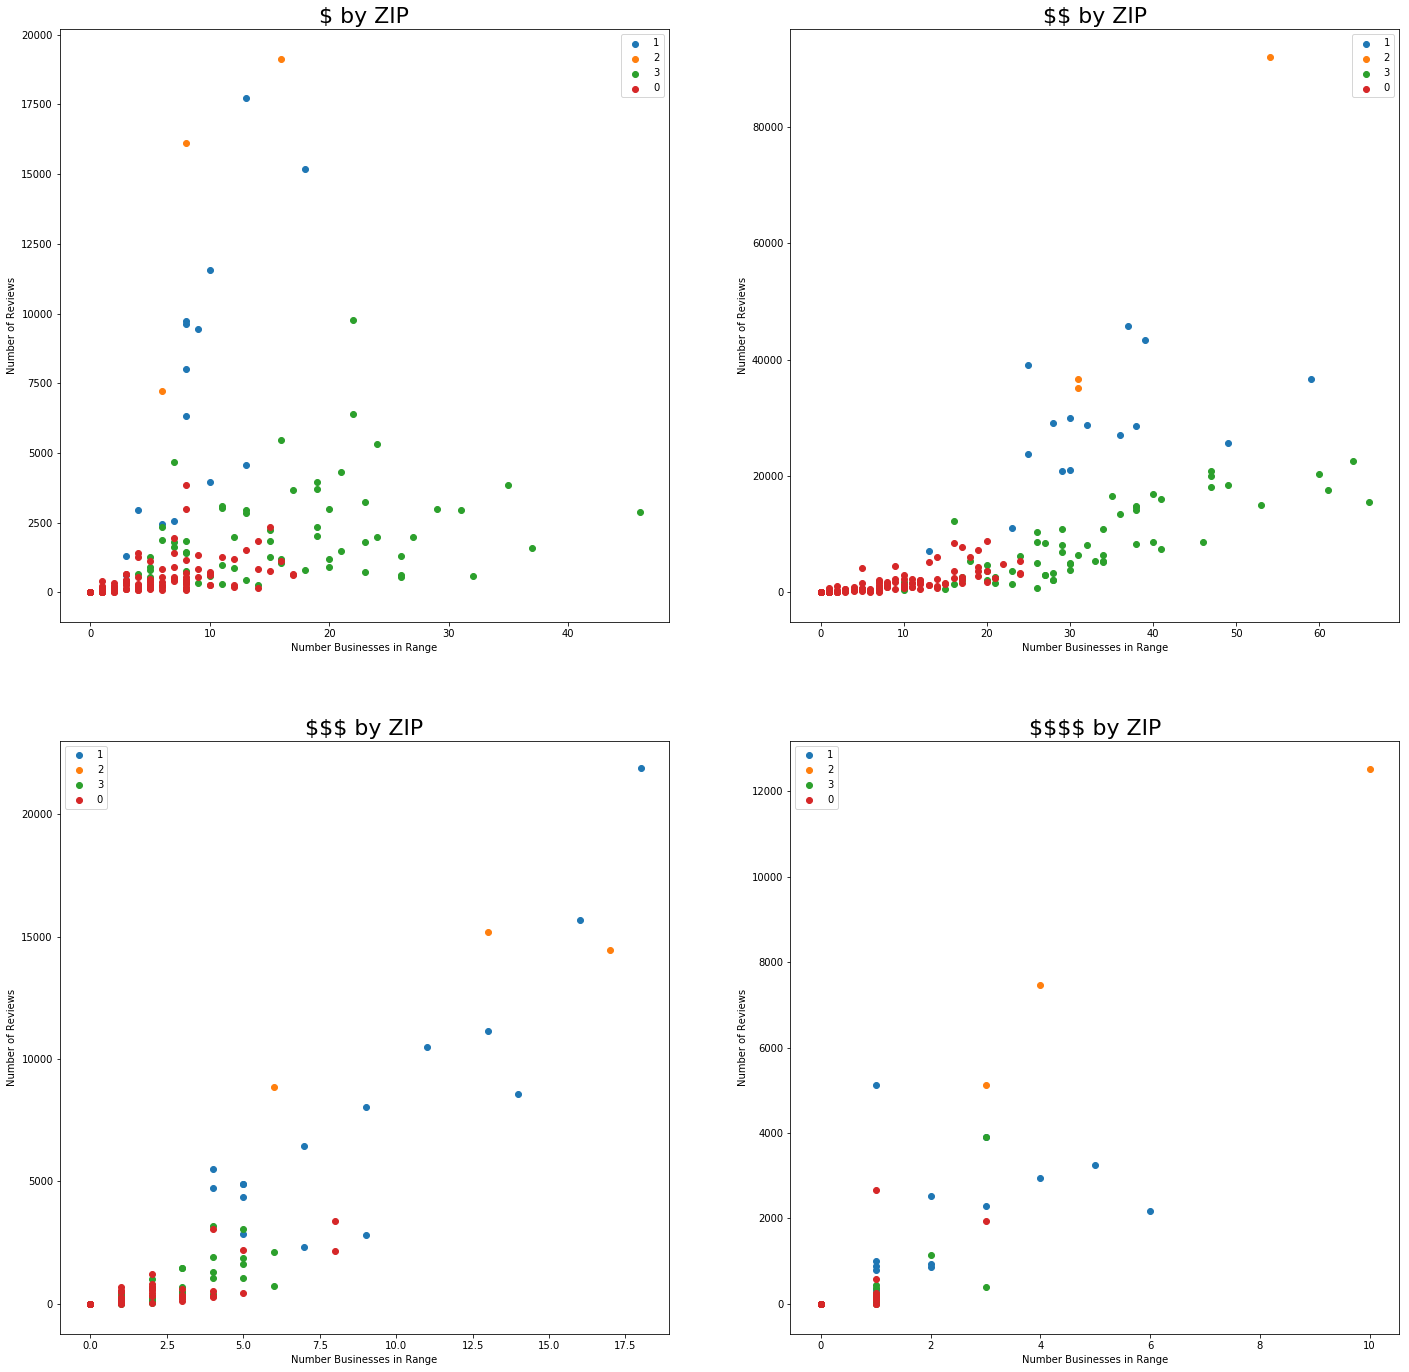

In [84]:
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()

for i in data.predicted4.unique():
    ax[0].scatter(data[data.predicted4==i].pr_1, data[data.predicted4==i].rv_1, label=str(i))
    ax[1].scatter(data[data.predicted4==i].pr_2, data[data.predicted4==i].rv_2, label=str(i))
    ax[2].scatter(data[data.predicted4==i].pr_3, data[data.predicted4==i].rv_3, label=str(i))
    ax[3].scatter(data[data.predicted4==i].pr_4, data[data.predicted4==i].rv_4, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range')
ax[0].set_ylabel('Number of Reviews')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range')
ax[1].set_ylabel('Number of Reviews')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range')
ax[2].set_ylabel('Number of Reviews')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range')
ax[3].set_ylabel('Number of Reviews')
ax[3].legend()

# Plot 10-D Results by Cluster - Standardized

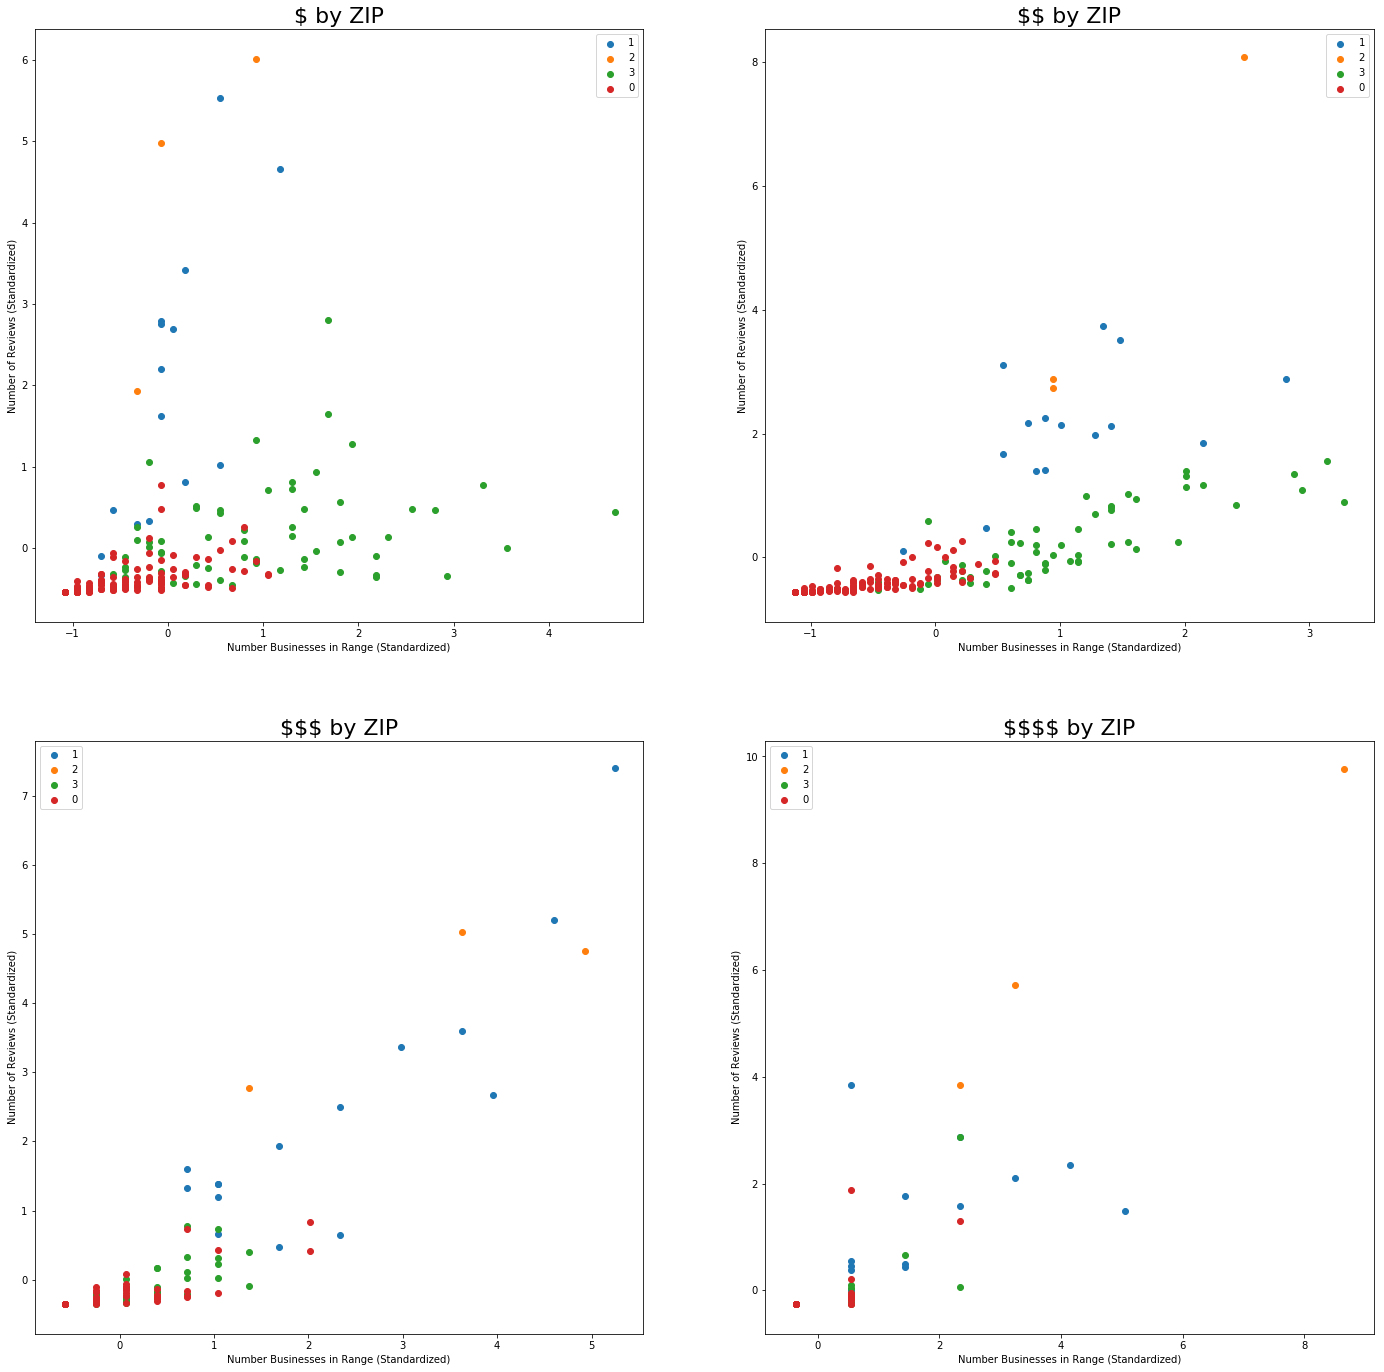

In [85]:
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()

for i in data.predicted4.unique():
    ax[0].scatter(data[data.predicted4==i].pr_1s, data[data.predicted4==i].rv_1s, label=str(i))
    ax[1].scatter(data[data.predicted4==i].pr_2s, data[data.predicted4==i].rv_2s, label=str(i))
    ax[2].scatter(data[data.predicted4==i].pr_3s, data[data.predicted4==i].rv_3s, label=str(i))
    ax[3].scatter(data[data.predicted4==i].pr_4s, data[data.predicted4==i].rv_4s, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range (Standardized)')
ax[0].set_ylabel('Number of Reviews (Standardized)')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range (Standardized)')
ax[1].set_ylabel('Number of Reviews (Standardized)')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range (Standardized)')
ax[2].set_ylabel('Number of Reviews (Standardized)')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range (Standardized)')
ax[3].set_ylabel('Number of Reviews (Standardized)')
ax[3].legend()

# Ploting k-means maps

## Geo Map background

In [10]:
import os
os.environ["PROJ_LIB"] = "/anaconda3/share/proj/";

In [11]:
from mpl_toolkits.basemap import Basemap

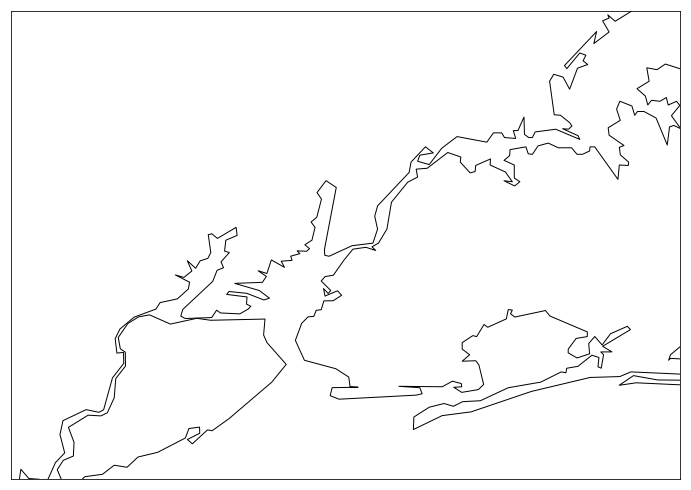

In [48]:
plt.figure(figsize=(12,12))
m = Basemap(projection='cyl', llcrnrlat=40.5, urcrnrlat=40.92, llcrnrlon=-74.3, urcrnrlon=-73.7, resolution='h')
m.drawcoastlines()
m.drawrivers()

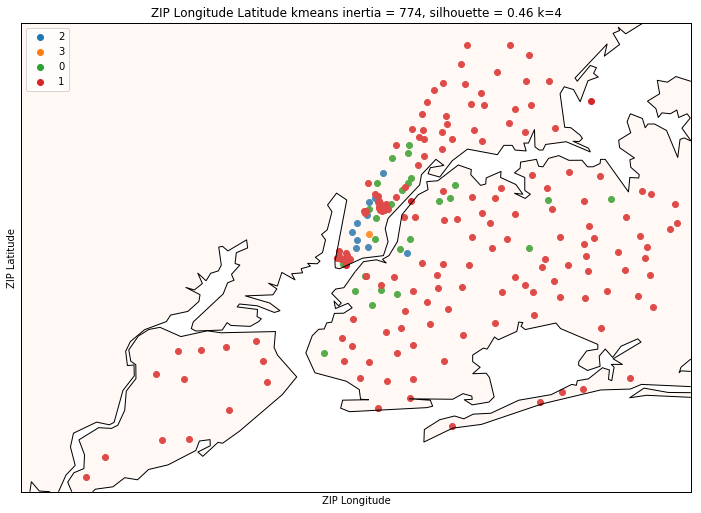

In [58]:
plt.figure(figsize=(12,12))
m = Basemap(projection='cyl', llcrnrlat=40.5, urcrnrlat=40.92, llcrnrlon=-74.3, urcrnrlon=-73.7, resolution='h')
m.fillcontinents(color="#FFDDCC", alpha=0.2)
#m.drawmapboundary(fill_color="#DDEEFF")
m.drawcoastlines()
m.drawmapboundary()

for i in data.predicted4.unique():
    plt.scatter(data[data.predicted4==i].avg_long, data[data.predicted4==i].avg_lat, label=str(i))

plt.title('ZIP Longitude Latitude kmeans inertia = 774, silhouette = 0.46 k=4')
plt.xlabel('ZIP Longitude')
plt.ylabel('ZIP Latitude')
plt.legend(loc=2)

# K-means = 5

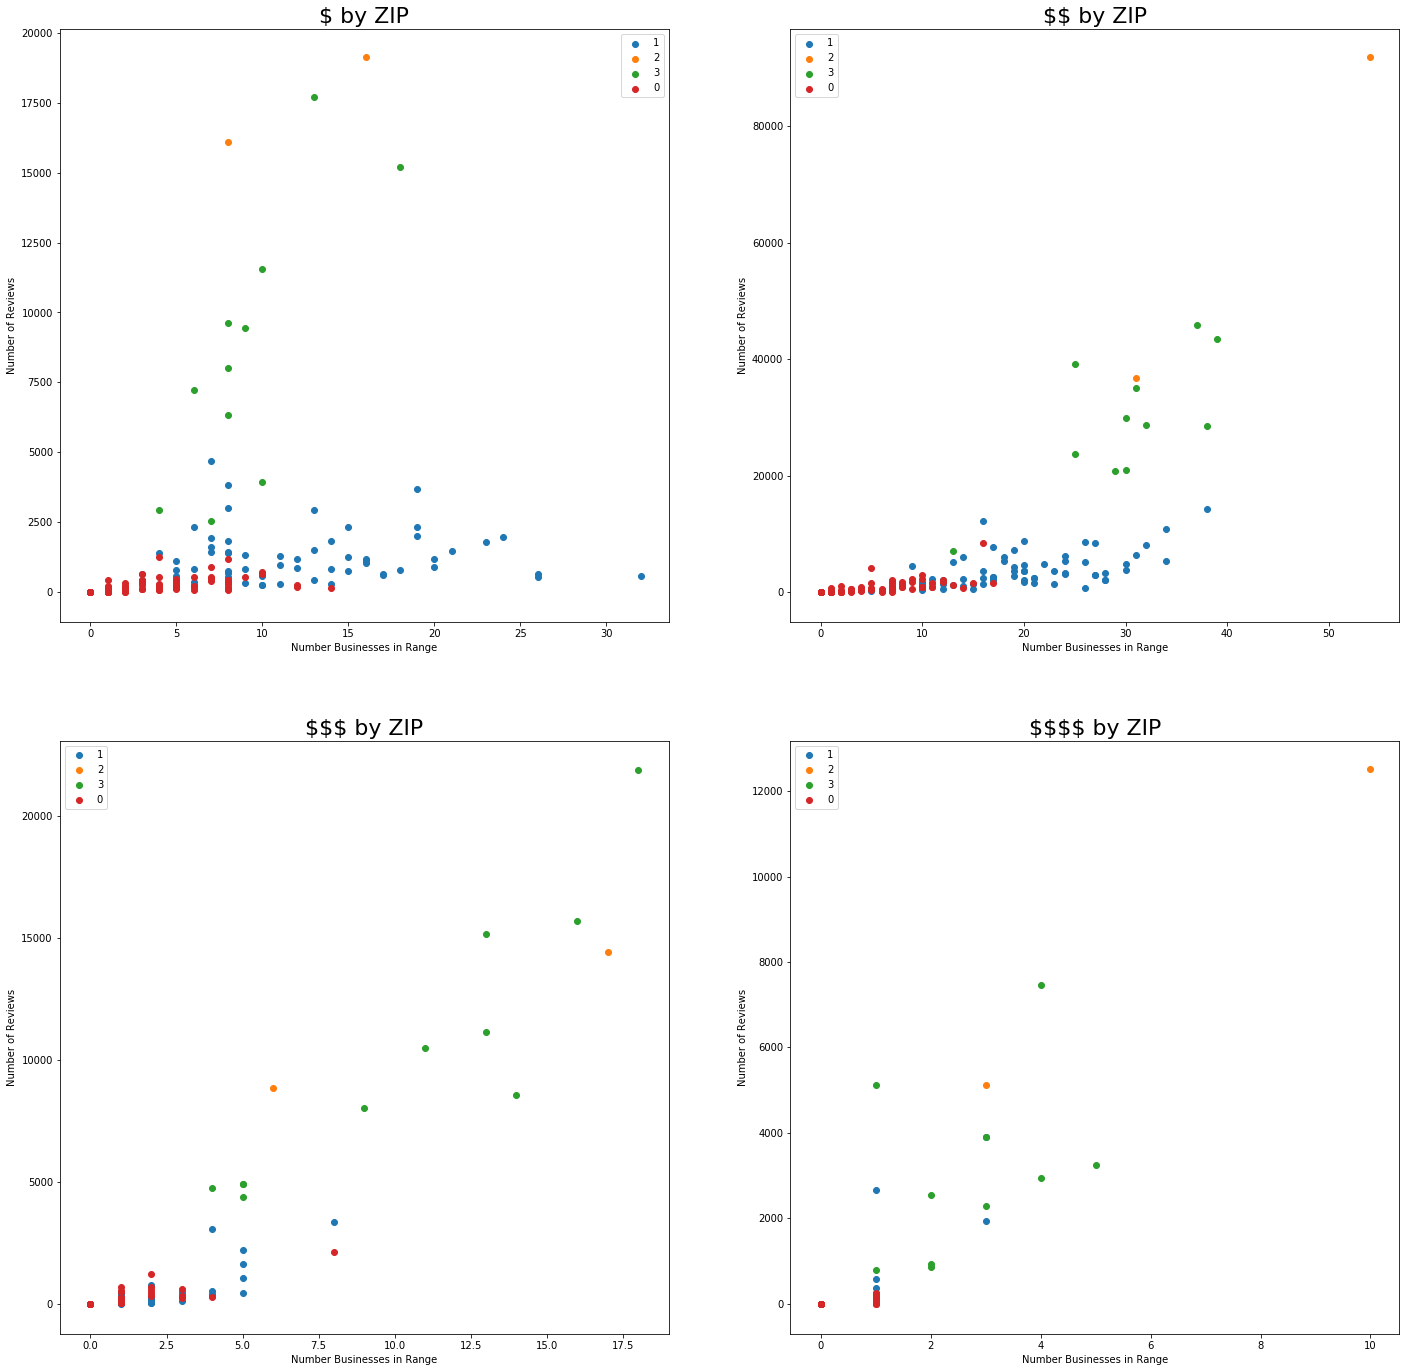

In [87]:
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()

for i in data.predicted4.unique():
    ax[0].scatter(data[data.predicted5==i].pr_1, data[data.predicted5==i].rv_1, label=str(i))
    ax[1].scatter(data[data.predicted5==i].pr_2, data[data.predicted5==i].rv_2, label=str(i))
    ax[2].scatter(data[data.predicted5==i].pr_3, data[data.predicted5==i].rv_3, label=str(i))
    ax[3].scatter(data[data.predicted5==i].pr_4, data[data.predicted5==i].rv_4, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range')
ax[0].set_ylabel('Number of Reviews')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range')
ax[1].set_ylabel('Number of Reviews')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range')
ax[2].set_ylabel('Number of Reviews')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range')
ax[3].set_ylabel('Number of Reviews')
ax[3].legend()

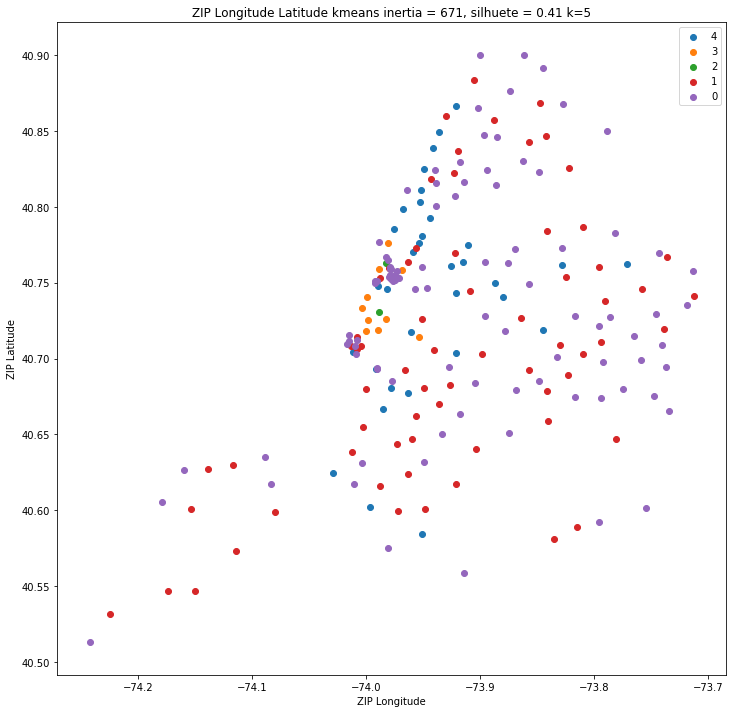

In [88]:
plt.figure(figsize=(12,12))
for i in data.predicted5.unique():
    plt.scatter(data[data.predicted5==i].avg_long, data[data.predicted5==i].avg_lat, label=str(i))

plt.title('ZIP Longitude Latitude kmeans inertia = 671, silhuete = 0.41 k=5')
plt.xlabel('ZIP Longitude')
plt.ylabel('ZIP Latitude')
plt.legend()

# K-means K=8

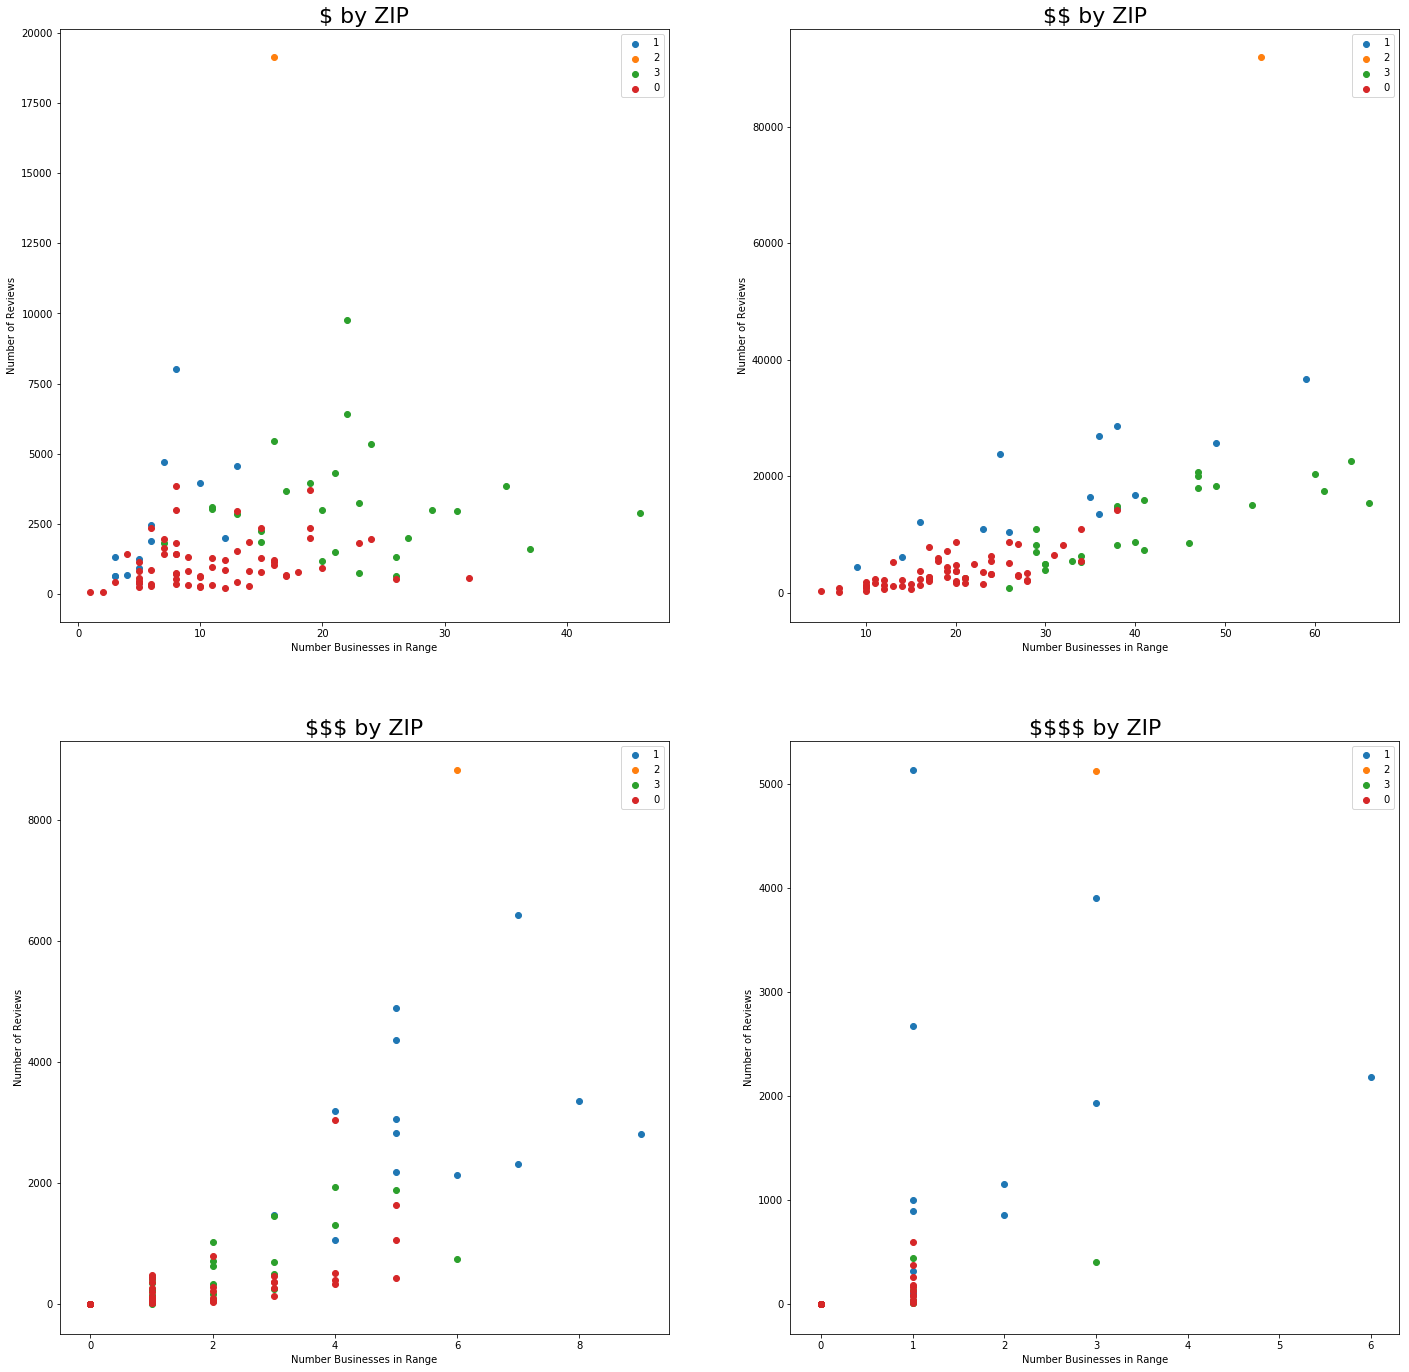

In [89]:
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()

for i in data.predicted4.unique():
    ax[0].scatter(data[data.predicted8==i].pr_1, data[data.predicted8==i].rv_1, label=str(i))
    ax[1].scatter(data[data.predicted8==i].pr_2, data[data.predicted8==i].rv_2, label=str(i))
    ax[2].scatter(data[data.predicted8==i].pr_3, data[data.predicted8==i].rv_3, label=str(i))
    ax[3].scatter(data[data.predicted8==i].pr_4, data[data.predicted8==i].rv_4, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range')
ax[0].set_ylabel('Number of Reviews')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range')
ax[1].set_ylabel('Number of Reviews')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range')
ax[2].set_ylabel('Number of Reviews')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range')
ax[3].set_ylabel('Number of Reviews')
ax[3].legend()

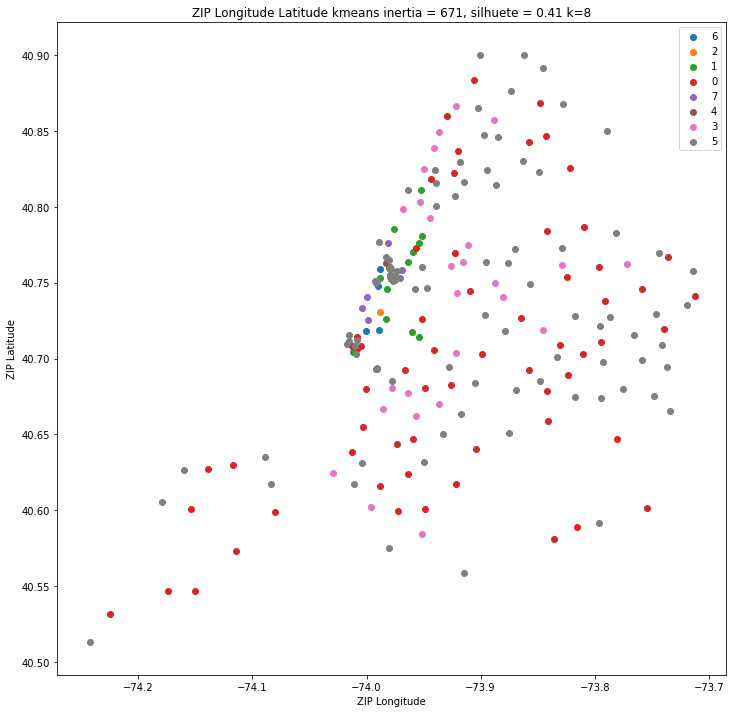

In [90]:
plt.figure(figsize=(12,12))
for i in data.predicted8.unique():
    plt.scatter(data[data.predicted8==i].avg_long, data[data.predicted8==i].avg_lat, label=str(i))

plt.title('ZIP Longitude Latitude kmeans inertia = 671, silhuete = 0.41 k=8')
plt.xlabel('ZIP Longitude')
plt.ylabel('ZIP Latitude')
plt.legend()

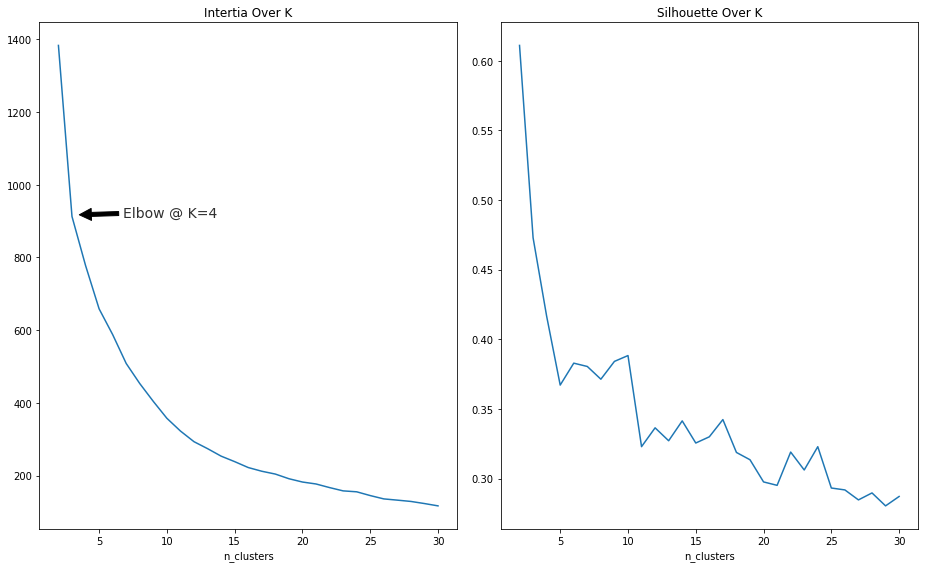

In [91]:
from sklearn.metrics import silhouette_score 
from sklearn.model_selection import ParameterGrid

class eval_kmeans:
    
    param_grid = dict(n_clusters=np.arange(2, 31))
    model = None
    scores = []
    
    def __init__(self, param_grid = None):
        
        if param_grid:
            self.param_grid = ParameterGrid(param_grid)
    
    def fit(self, X, scorer="silhouette"):
        
        ## This isn't very smart ATM.  Only one param, K, is being searched.
        for param, values in self.param_grid.items():
            
            for value in values:
        
                estimator = KMeans(n_clusters = value,)
                model = estimator.fit(X)
                
                # Populate scores
                score    = silhouette_score(X, model.labels_)
                
                self.scores.append({
                    param:        value,
                    "inertia":    model.inertia_,
                    "silhouette": score
                })
                
    def get_scores(self):
        return pd.DataFrame(self.scores)
    
kmeans = eval_kmeans()
kmeans.fit(data[features])

eval_scores = kmeans.get_scores()
eval_scores.set_index("n_clusters", inplace=True)

fig, ax = plt.subplots(ncols=2, figsize=(13, 8))
eval_scores["inertia"].plot(ax=ax[0], title="Intertia Over K")
eval_scores["silhouette"].plot(ax=ax[1], title="Silhouette Over K")

# Add the arrow!
# ax[0].arrow(3, 370, 5, 105, head_width=3, head_length=10, fc='k', ec='k')
ax[0].annotate('Elbow @ K=4', xy = (0.09, .62),  xycoords = 'axes fraction', \
    xytext = (0.2, 0.615), fontsize = 14, \
    color = '#303030', arrowprops=dict(facecolor='black', shrink=0.05))

fig.tight_layout()

# Hierarcical clustering

In [92]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import centroid, fcluster
from scipy.spatial.distance import pdist

In [93]:
def hierarchy_plot(X,p_input,truncate,link_method_list):
    """
    :param X: Pandas DF
        Data to cluster.
    :param p_input: int
        The ``p`` parameter for ``truncate_mode``.
    :param truncate: str, optional
        Truncation is used to condense the dendrogram.
        Example: ``None``,``'lastp'``, ``'level'``.
    :param link_method_list: list of str
        Methods used to compute the distance.
        Example: 'ward', 'single', 'centroid'...
    :return: nothing,
        Plots dendograms
    """
    # Generating Linkage list
    z_list = [hierarchy.linkage(X, method=z) for z in link_method_list]
    # Color Pallete set up
    hierarchy.set_link_color_palette(['m', 'c', 'y', 'k'])

    # Setting Sub Plots
    fig, axes = plt.subplots(max(2,len(link_method_list)//2),
                             2,
                             figsize=(20, 25))
    #
    for pos,Z in enumerate(z_list):
        pos_x = min(pos // 2 + pos % 2, pos // 2)
        pos_y = max(pos % 2, pos % 2)
        hierarchy.dendrogram(Z, ax=axes[pos_x][pos_y], p=p_input, above_threshold_color='y',
                             orientation='right', truncate_mode=truncate)
        axes[pos_x, pos_y].set_title("Metric: " + link_method_list[pos]
                                     + ", p=" +str(p_input) 
                                     + ", truncate = " + truncate
                                     , fontsize=15)

    hierarchy.set_link_color_palette(None)
    plt.figure()

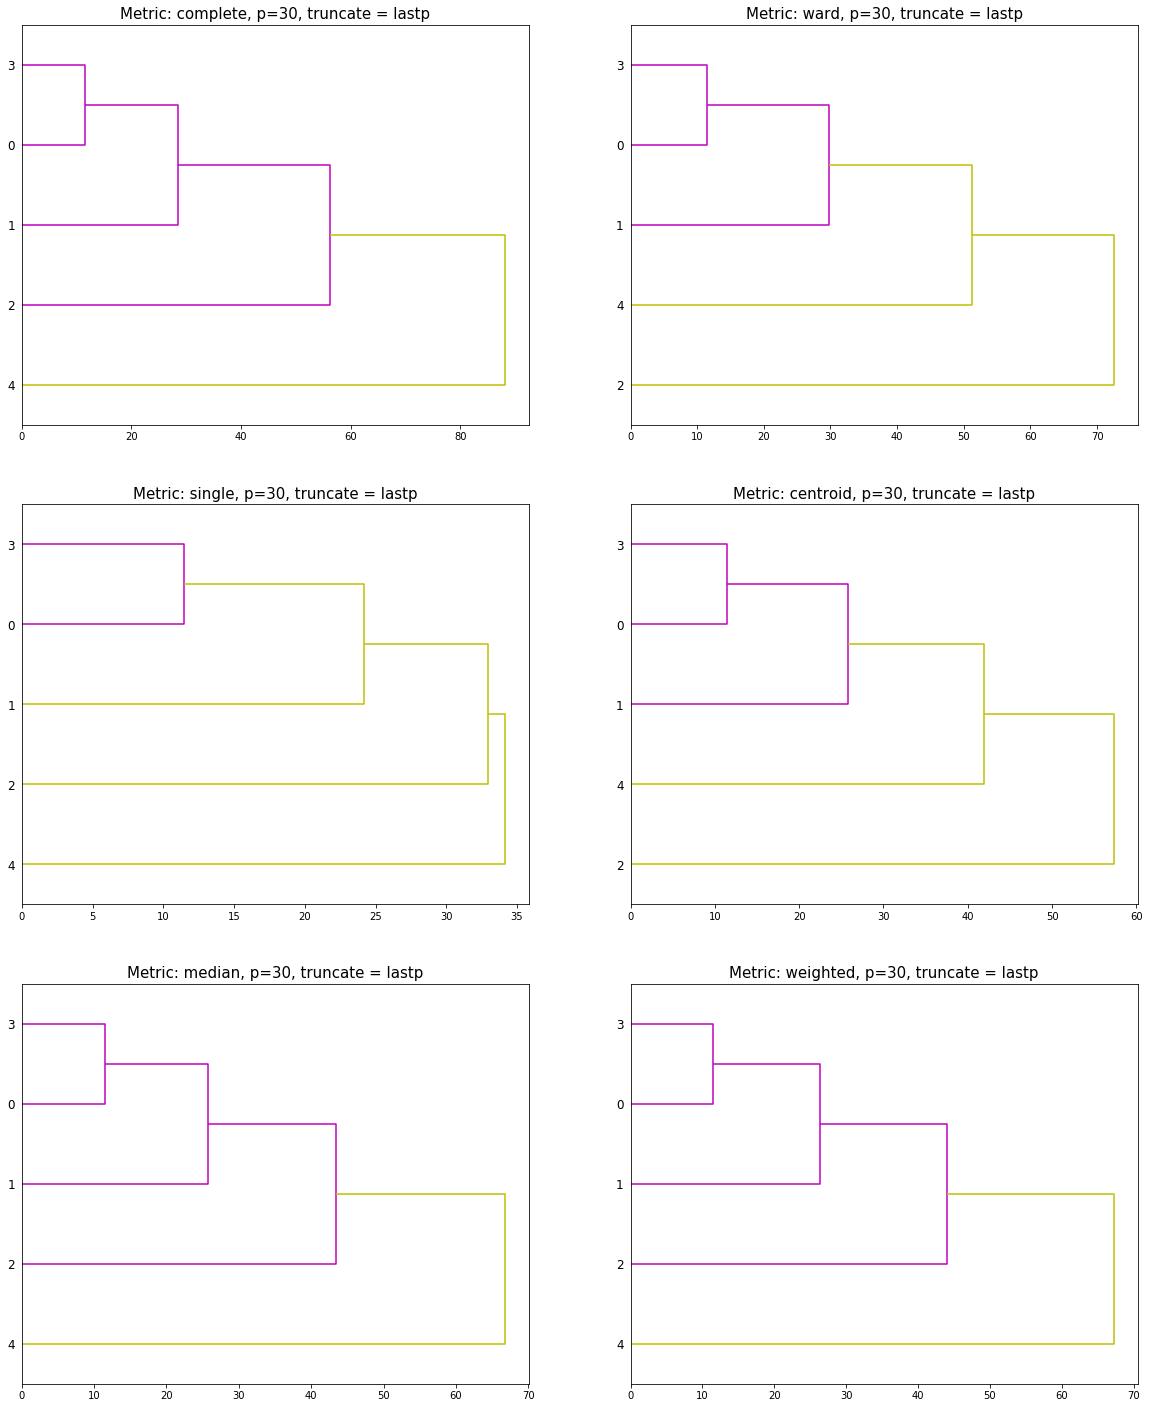

<Figure size 432x288 with 0 Axes>

In [94]:
link_methods = ['complete','ward', 'single', 'centroid','median','weighted']
hierarchy_plot(data[['pr_1','pr_2m','pr_3m','pr_4m']].head(),30,'lastp',link_methods)
# data[features]

In [95]:
z = hierarchy.linkage(data[features], method='complete') 
cls = hierarchy.fcluster(z, 4, 'maxclust')

In [96]:
data['predicted_hier_6'] = cls

In [97]:
data['predicted_hier_6']

0      4
1      4
2      1
3      3
4      3
5      3
6      3
7      4
8      4
9      4
10     4
11     4
12     3
13     4
14     3
15     2
16     3
17     3
18     4
19     4
20     3
21     3
22     3
23     3
24     3
25     3
26     3
27     3
28     3
29     3
      ..
180    3
181    3
182    3
183    3
184    3
185    3
186    3
187    3
188    3
189    3
190    3
191    3
192    3
193    3
194    3
195    3
196    3
197    3
198    3
199    3
200    3
201    3
202    3
203    3
204    3
205    3
206    3
207    3
208    3
209    3
Name: predicted_hier_6, Length: 210, dtype: int32

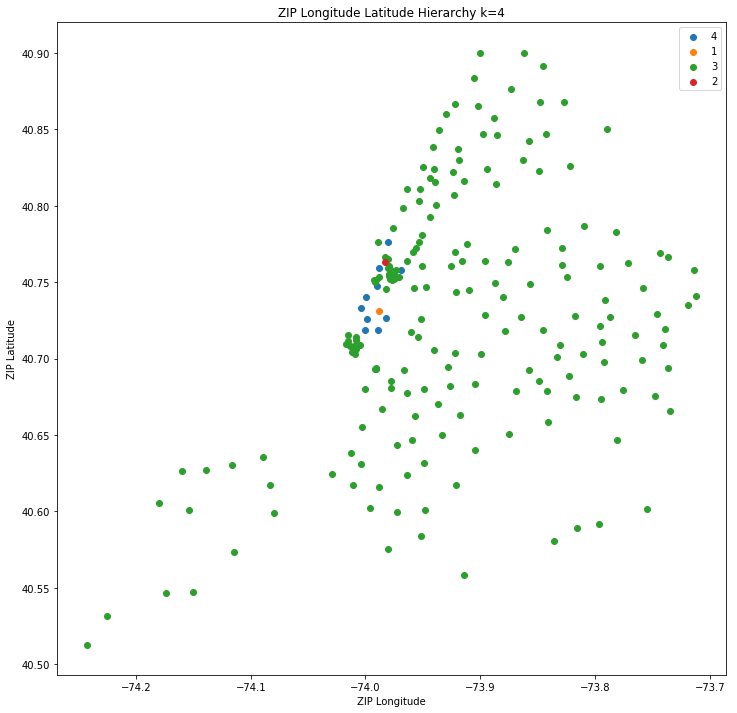

In [98]:
plt.figure(figsize=(12,12))
for i in data.predicted_hier_6.unique():
    plt.scatter(data[data.predicted_hier_6==i].avg_long, data[data.predicted_hier_6==i].avg_lat, label=str(i))

plt.title('ZIP Longitude Latitude Hierarchy k=4')
plt.xlabel('ZIP Longitude')
plt.ylabel('ZIP Latitude')
plt.legend()

# DBSCAN

In [182]:
from sklearn.cluster import DBSCAN

In [372]:
features = ['pr_1s','rv_1s','pr_2ms','rv_2s','pr_3ms','rv_3s','pr_4ms','rv_4s','pr_tots','rv_tots','pr_totms']

In [373]:
data.columns

Index(['zip', 'city', 'state', 'cat', 'pr_1', 'rv_1', 'pr_2', 'rv_2', 'pr_3',
       'rv_3', 'pr_4', 'rv_4', 'avg_lat', 'avg_long', 'predicted', 'pr_1s',
       'rv_1s', 'pr_2s', 'rv_2s', 'pr_3s', 'rv_3s', 'pr_4s', 'rv_4s', 'pr_2m',
       'pr_3m', 'pr_4m', 'pr_2ms', 'pr_3ms', 'pr_4ms', 'db_pred', 'pr_tot',
       'rv_tot', 'pr_totm', 'pr_tots', 'rv_tots', 'pr_totms', 'ac_pred'],
      dtype='object')

In [383]:
dbscan = DBSCAN(eps=.3, min_samples=3).fit(data[features])

In [384]:
data['db_pred'] = dbscan.labels_

In [385]:
data.db_pred.value_counts(sort=False)

-1    44
 0     3
 2    17
 1     4
Name: db_pred, dtype: int64

# Plot 10-D DBSCAN Results by Cluster - Raw

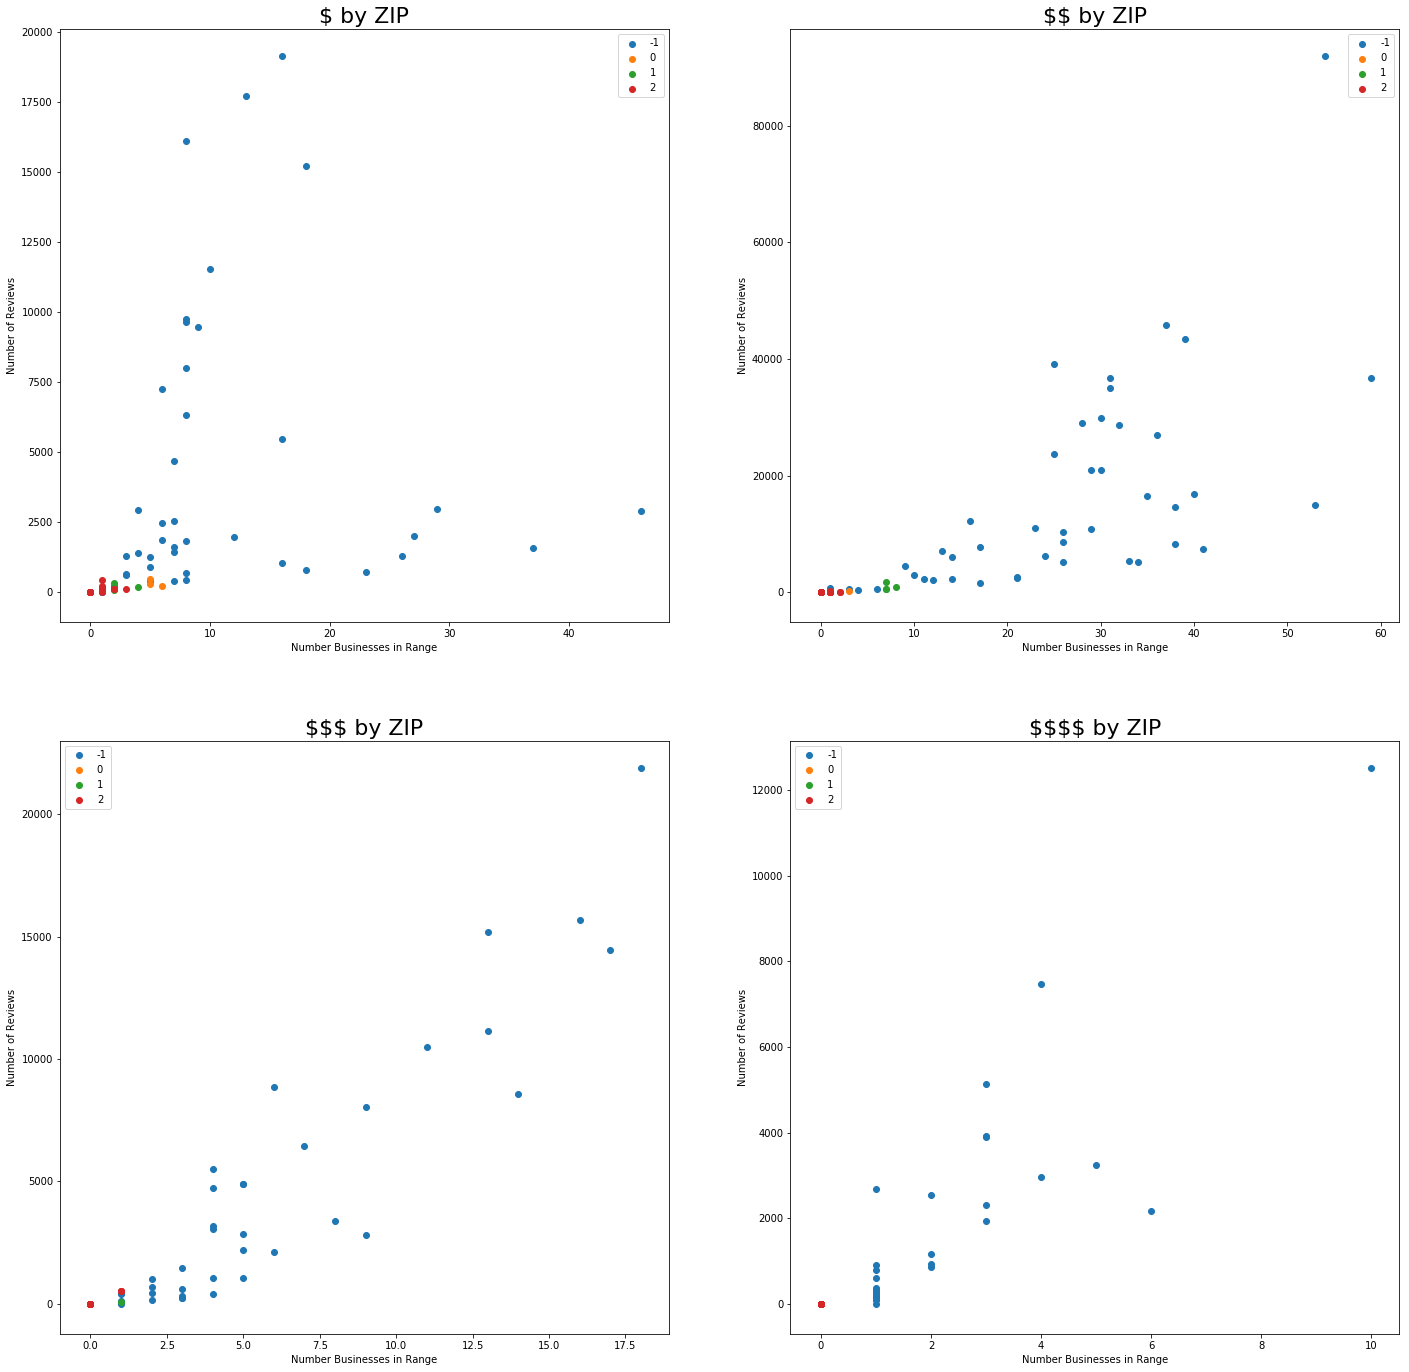

In [386]:
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()

for i in data.db_pred.unique():
    ax[0].scatter(data[data.db_pred==i].pr_1, data[data.db_pred==i].rv_1, label=str(i))
    ax[1].scatter(data[data.db_pred==i].pr_2, data[data.db_pred==i].rv_2, label=str(i))
    ax[2].scatter(data[data.db_pred==i].pr_3, data[data.db_pred==i].rv_3, label=str(i))
    ax[3].scatter(data[data.db_pred==i].pr_4, data[data.db_pred==i].rv_4, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range')
ax[0].set_ylabel('Number of Reviews')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range')
ax[1].set_ylabel('Number of Reviews')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range')
ax[2].set_ylabel('Number of Reviews')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range')
ax[3].set_ylabel('Number of Reviews')
ax[3].legend()

# Plot 10-D DBSCAN Results by Cluster - Standardized

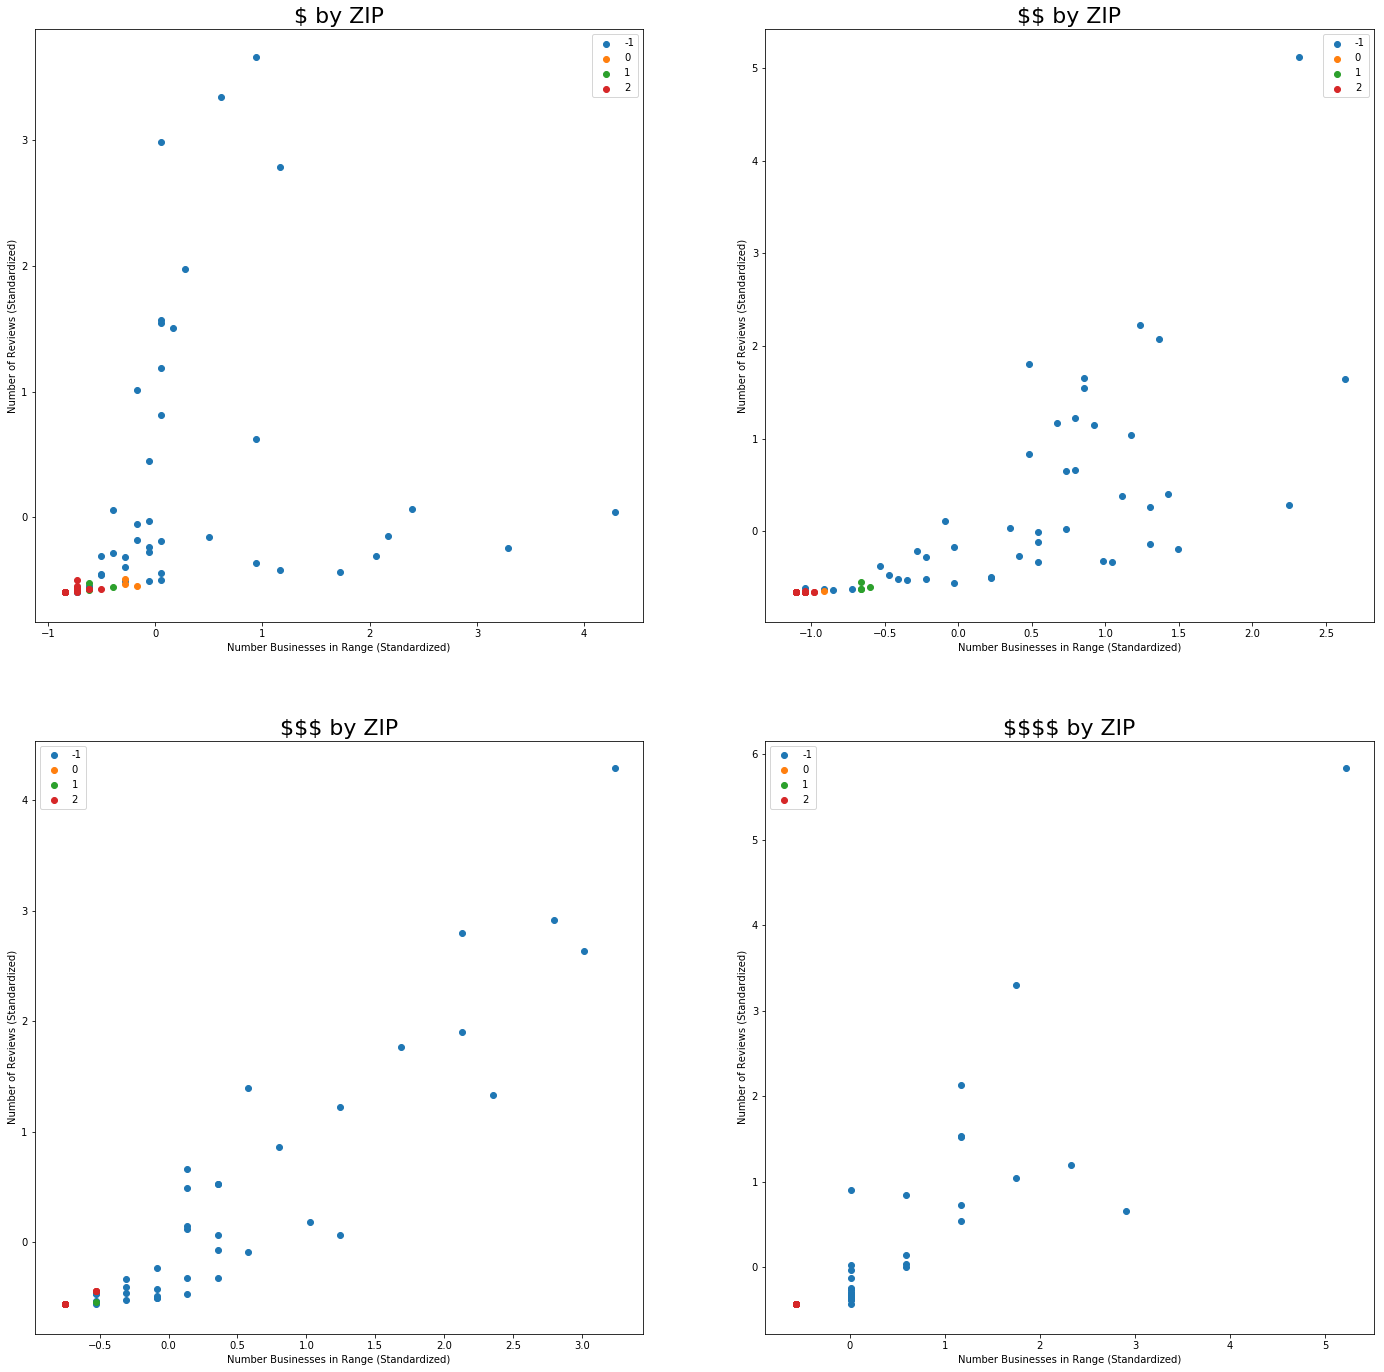

In [387]:
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()

for i in data.db_pred.unique():
    ax[0].scatter(data[data.db_pred==i].pr_1s, data[data.db_pred==i].rv_1s, label=str(i))
    ax[1].scatter(data[data.db_pred==i].pr_2s, data[data.db_pred==i].rv_2s, label=str(i))
    ax[2].scatter(data[data.db_pred==i].pr_3s, data[data.db_pred==i].rv_3s, label=str(i))
    ax[3].scatter(data[data.db_pred==i].pr_4s, data[data.db_pred==i].rv_4s, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range (Standardized)')
ax[0].set_ylabel('Number of Reviews (Standardized)')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range (Standardized)')
ax[1].set_ylabel('Number of Reviews (Standardized)')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range (Standardized)')
ax[2].set_ylabel('Number of Reviews (Standardized)')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range (Standardized)')
ax[3].set_ylabel('Number of Reviews (Standardized)')
ax[3].legend()

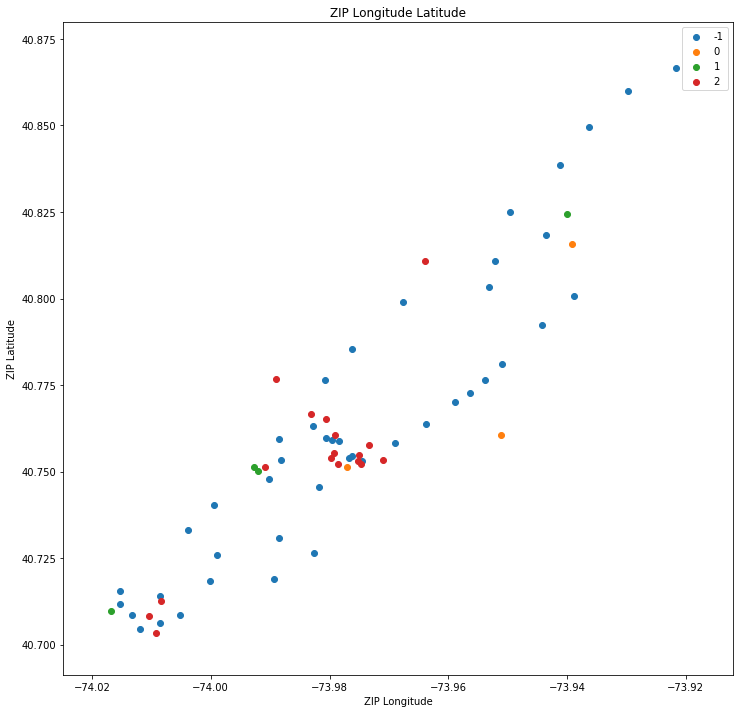

In [388]:
plt.figure(figsize=(12,12))
for i in data.db_pred.unique():
    plt.scatter(data[data.db_pred==i].avg_long, data[data.db_pred==i].avg_lat, label=str(i))

plt.title('ZIP Longitude Latitude')
plt.xlabel('ZIP Longitude')
plt.ylabel('ZIP Latitude')
plt.legend()

In [353]:
data[data.db_pred==0]

,zip,city,state,cat,pr_1,rv_1,pr_2,rv_2,pr_3,rv_3,...,pr_2ms,pr_3ms,pr_4ms,db_pred,pr_tot,rv_tot,pr_totm,pr_tots,rv_tots,pr_totms
4,10005,New York,NY,none,7,1425,11,2268,1,89,...,-0.407823,-0.527679,0.008512,0,20,3959,36,-0.373677,-0.510751,-0.421682
31,10035,New York,NY,none,8,437,12,2134,0,0,...,-0.344508,-0.749174,-0.570280,0,20,2571,32,-0.373677,-0.567233,-0.504020
33,10037,New York,NY,none,5,287,1,93,0,0,...,-1.040972,-0.749174,-0.570280,0,6,380,7,-0.934781,-0.656391,-1.018636
35,10039,New York,NY,none,2,64,7,478,0,0,...,-0.661082,-0.749174,-0.570280,0,9,542,16,-0.814544,-0.649799,-0.833374
36,10040,New York,NY,none,8,687,14,2231,1,469,...,-0.217878,-0.527679,-0.570280,0,23,3387,39,-0.253440,-0.534027,-0.359928
37,10041,New York,NY,none,0,0,1,14,0,0,...,-1.040972,-0.749174,-0.570280,0,1,14,2,-1.135175,-0.671285,-1.121559
38,10044,New York,NY,none,6,211,3,222,0,0,...,-0.914342,-0.749174,-0.570280,0,9,433,12,-0.814544,-0.654234,-0.915712
40,10069,New York,NY,none,1,45,0,0,0,0,...,-1.104287,-0.749174,-0.570280,0,1,45,1,-1.135175,-0.670023,-1.142143
41,10075,New York,NY,none,4,1402,17,7801,4,3049,...,-0.027933,0.136806,0.008512,0,26,12845,54,-0.133203,-0.149154,-0.051159
42,10104,New York,NY,none,1,142,1,238,0,0,...,-1.040972,-0.749174,-0.570280,0,2,380,3,-1.095096,-0.656391,-1.100974


In [60]:
from sklearn.cluster import AgglomerativeClustering

In [65]:
ac = AgglomerativeClustering(n_clusters=5)

In [66]:
ac.fit(data[features])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [67]:
data['ac_pred'] = ac.labels_

In [68]:
data.ac_pred.value_counts(sort=False)

0     44
1      7
2    150
3      1
4      8
Name: ac_pred, dtype: int64

In [ ]:
ac.fit_predict()

# Plot 10-D Agglomerative Clustering Results by Cluster - Raw

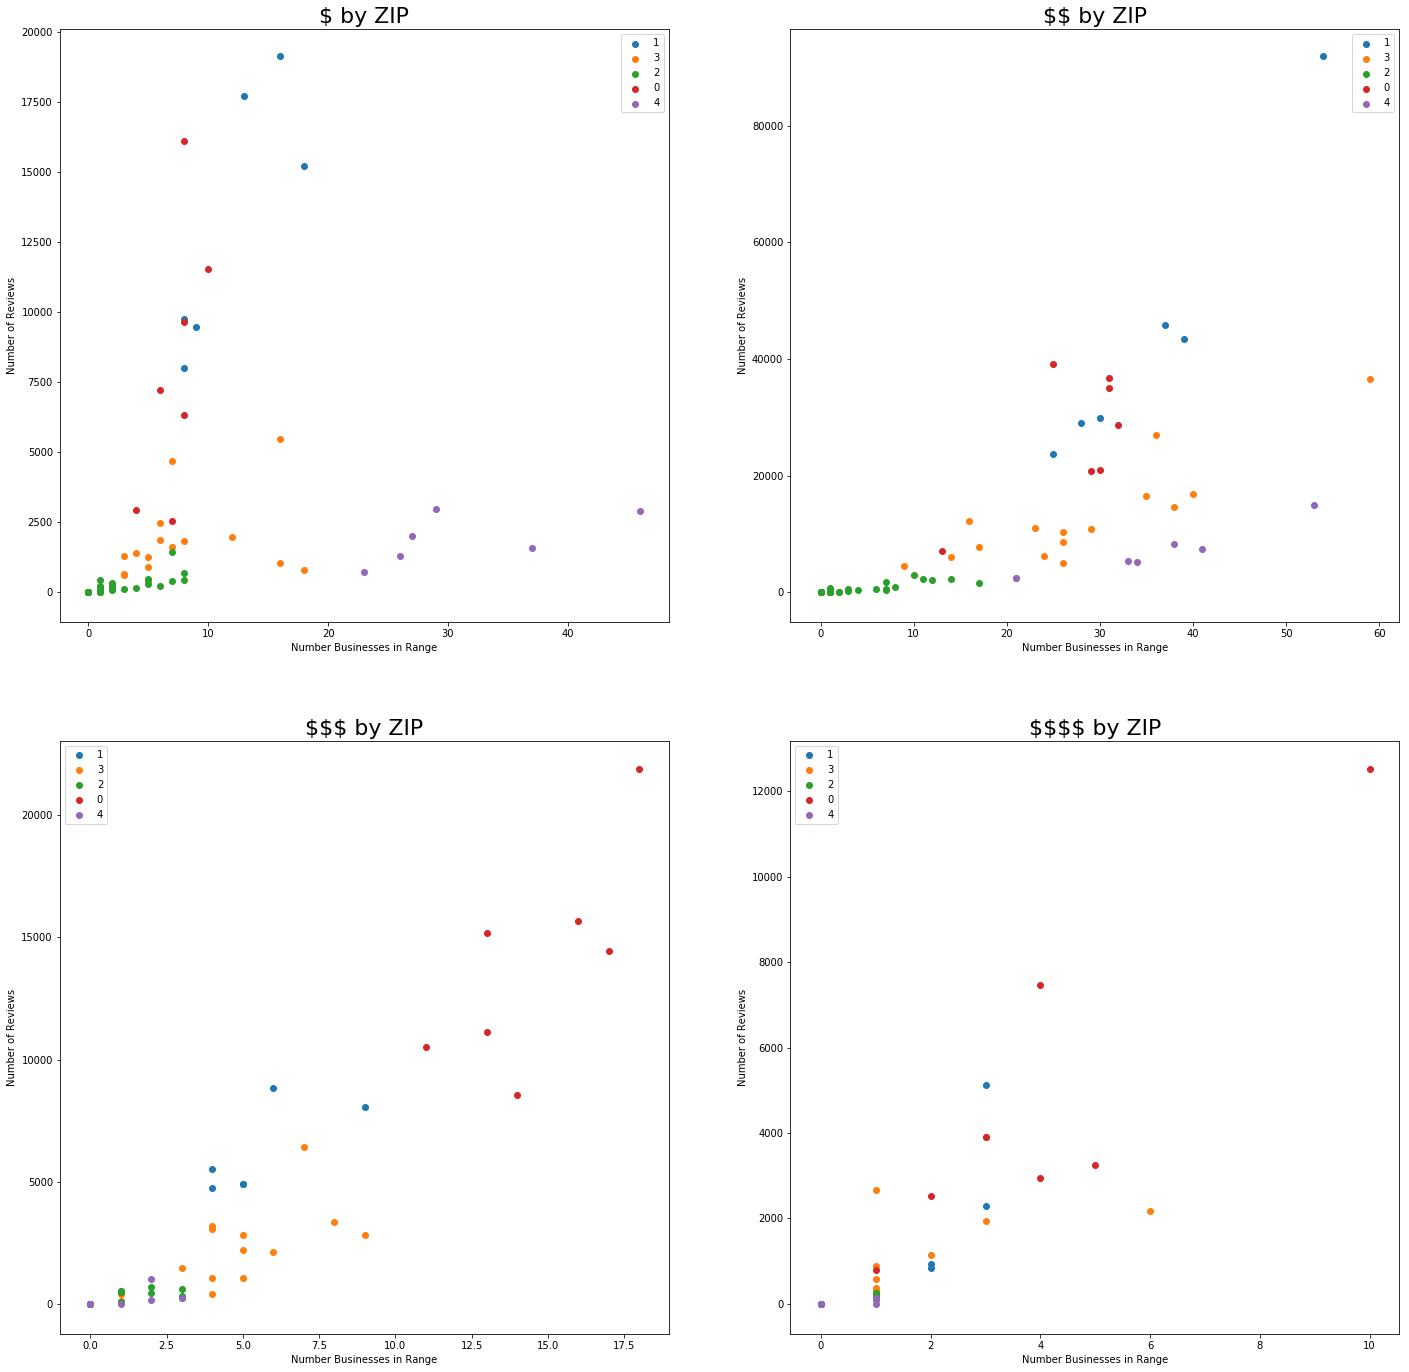

In [361]:
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()

for i in data.ac_pred.unique():
    ax[0].scatter(data[data.ac_pred==i].pr_1, data[data.ac_pred==i].rv_1, label=str(i))
    ax[1].scatter(data[data.ac_pred==i].pr_2, data[data.ac_pred==i].rv_2, label=str(i))
    ax[2].scatter(data[data.ac_pred==i].pr_3, data[data.ac_pred==i].rv_3, label=str(i))
    ax[3].scatter(data[data.ac_pred==i].pr_4, data[data.ac_pred==i].rv_4, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range')
ax[0].set_ylabel('Number of Reviews')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range')
ax[1].set_ylabel('Number of Reviews')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range')
ax[2].set_ylabel('Number of Reviews')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range')
ax[3].set_ylabel('Number of Reviews')
ax[3].legend()

# Plot 10-D Agglomerative Clustering Results by Cluster - Standardized

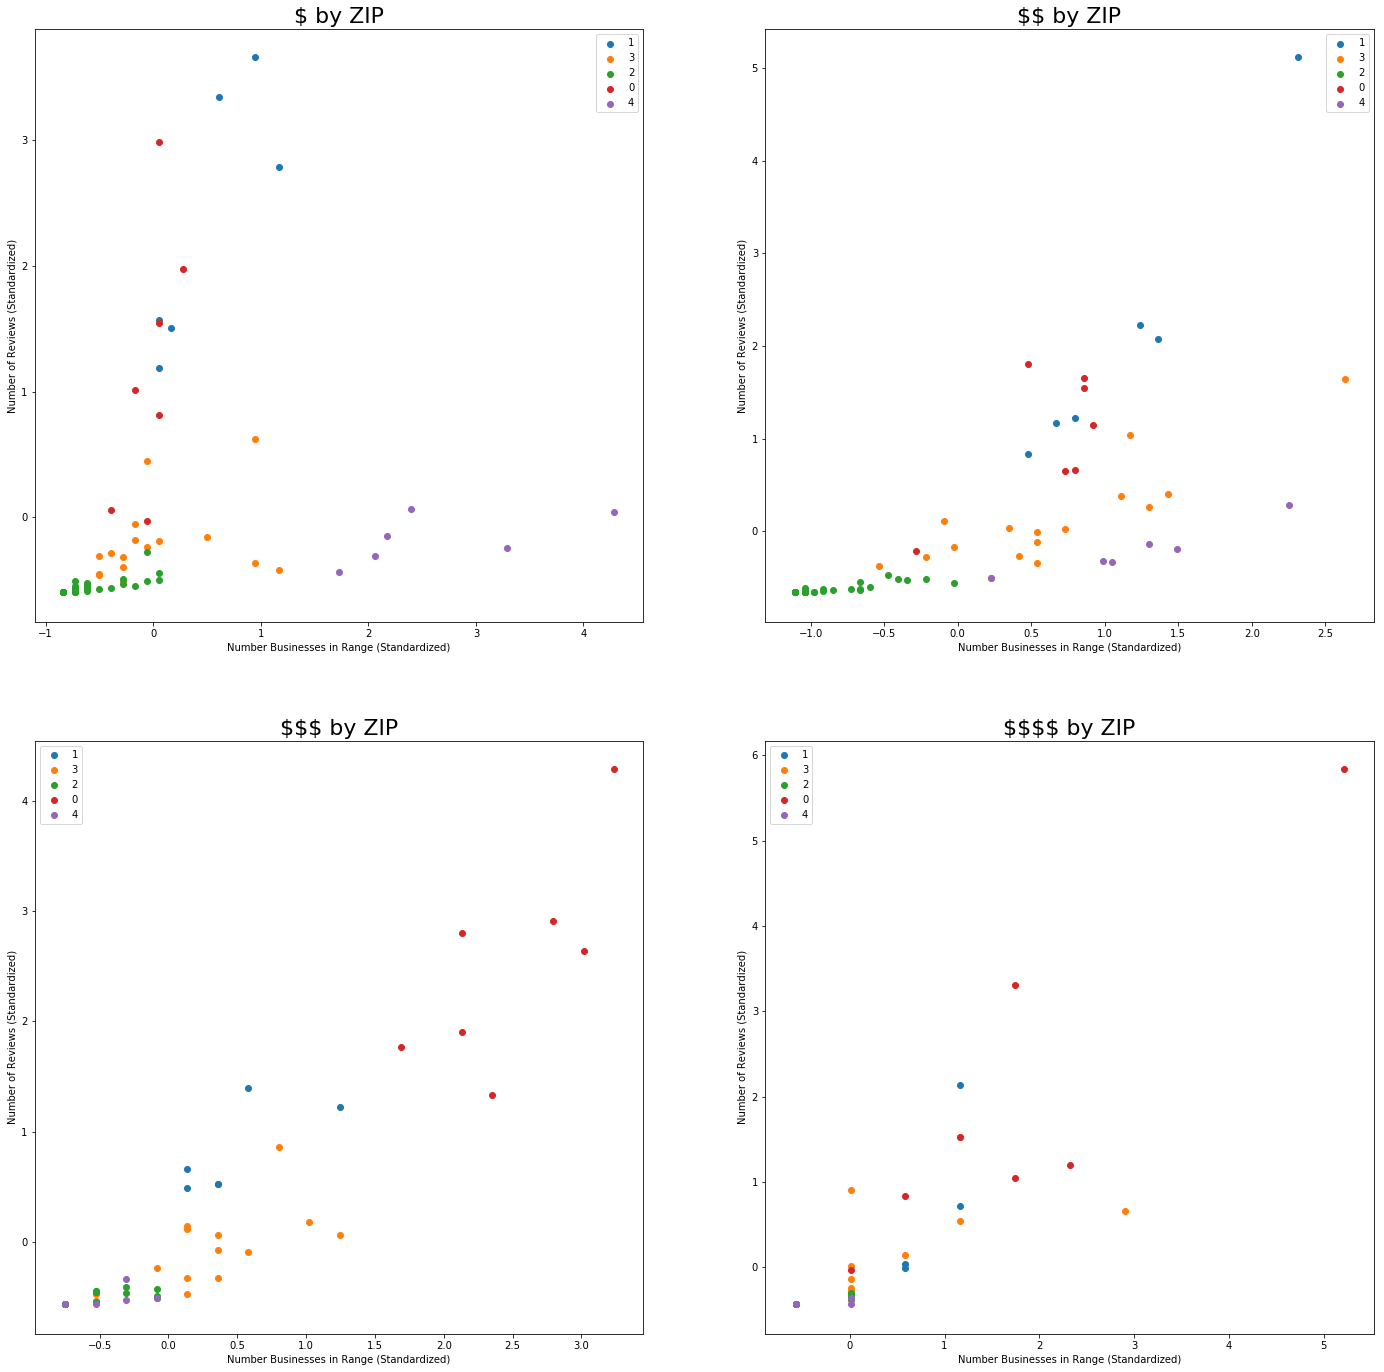

In [362]:
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()

for i in data.ac_pred.unique():
    ax[0].scatter(data[data.ac_pred==i].pr_1s, data[data.ac_pred==i].rv_1s, label=str(i))
    ax[1].scatter(data[data.ac_pred==i].pr_2s, data[data.ac_pred==i].rv_2s, label=str(i))
    ax[2].scatter(data[data.ac_pred==i].pr_3s, data[data.ac_pred==i].rv_3s, label=str(i))
    ax[3].scatter(data[data.ac_pred==i].pr_4s, data[data.ac_pred==i].rv_4s, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range (Standardized)')
ax[0].set_ylabel('Number of Reviews (Standardized)')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range (Standardized)')
ax[1].set_ylabel('Number of Reviews (Standardized)')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range (Standardized)')
ax[2].set_ylabel('Number of Reviews (Standardized)')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range (Standardized)')
ax[3].set_ylabel('Number of Reviews (Standardized)')
ax[3].legend()

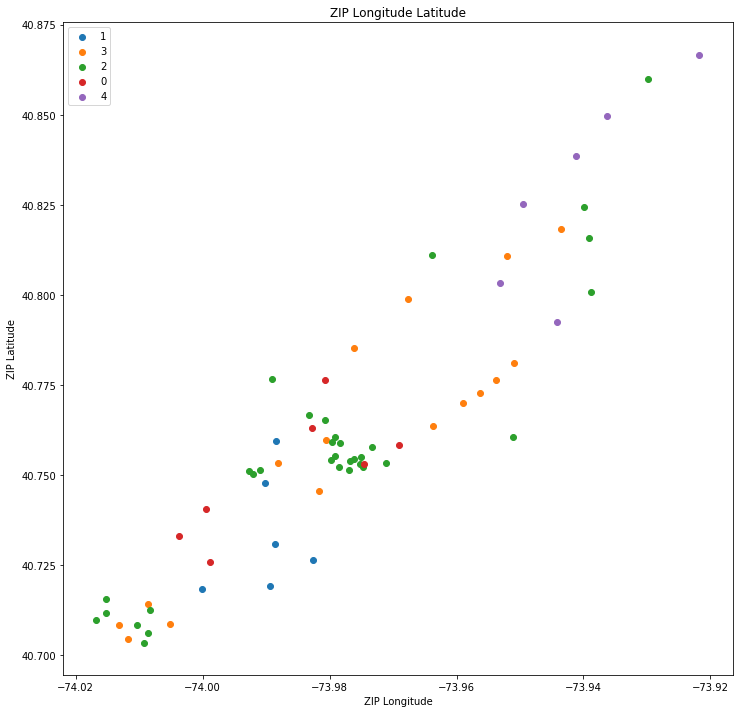

In [363]:
plt.figure(figsize=(12,12))
for i in data.ac_pred.unique():
    plt.scatter(data[data.ac_pred==i].avg_long, data[data.ac_pred==i].avg_lat, label=str(i))

plt.title('ZIP Longitude Latitude')
plt.xlabel('ZIP Longitude')
plt.ylabel('ZIP Latitude')
plt.legend()

# Model Exploration

In [389]:
data.columns

Index(['zip', 'city', 'state', 'cat', 'pr_1', 'rv_1', 'pr_2', 'rv_2', 'pr_3',
       'rv_3', 'pr_4', 'rv_4', 'avg_lat', 'avg_long', 'predicted', 'pr_1s',
       'rv_1s', 'pr_2s', 'rv_2s', 'pr_3s', 'rv_3s', 'pr_4s', 'rv_4s', 'pr_2m',
       'pr_3m', 'pr_4m', 'pr_2ms', 'pr_3ms', 'pr_4ms', 'db_pred', 'pr_tot',
       'rv_tot', 'pr_totm', 'pr_tots', 'rv_tots', 'pr_totms', 'ac_pred'],
      dtype='object')

In [396]:
features = ['pr_1s','pr_2ms','pr_3ms','pr_4ms']

In [84]:
data[['pr_1s','pr_2ms','pr_3ms','pr_4ms']]

,pr_1s,pr_2ms,pr_3ms,pr_4ms
0,-0.076430,0.744687,0.718349,-0.360598
1,1.177496,1.478260,0.718349,-0.360598
2,0.926711,2.478587,1.365789,2.343887
3,0.425140,0.611311,1.365789,1.442392
4,-0.201822,-0.389016,-0.252810,0.540897
5,0.926711,0.611311,0.718349,-0.360598
6,-0.201822,0.477934,1.042069,0.540897
7,-0.076430,0.544622,1.042069,1.442392
8,-0.327215,0.944753,3.631826,3.245383
9,0.174355,0.544622,5.250424,0.540897


In [397]:
ac.fit(data[features])

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='ward', memory=None, n_clusters=5,
            pooling_func='deprecated')

In [398]:
data['ac_pred_1'] = ac.labels_

In [59]:
ac.labels_

NameError: name 'ac' is not defined

In [399]:
data.ac_pred_1.value_counts()

3    33
0    17
2    10
1     7
4     1
Name: ac_pred_1, dtype: int64

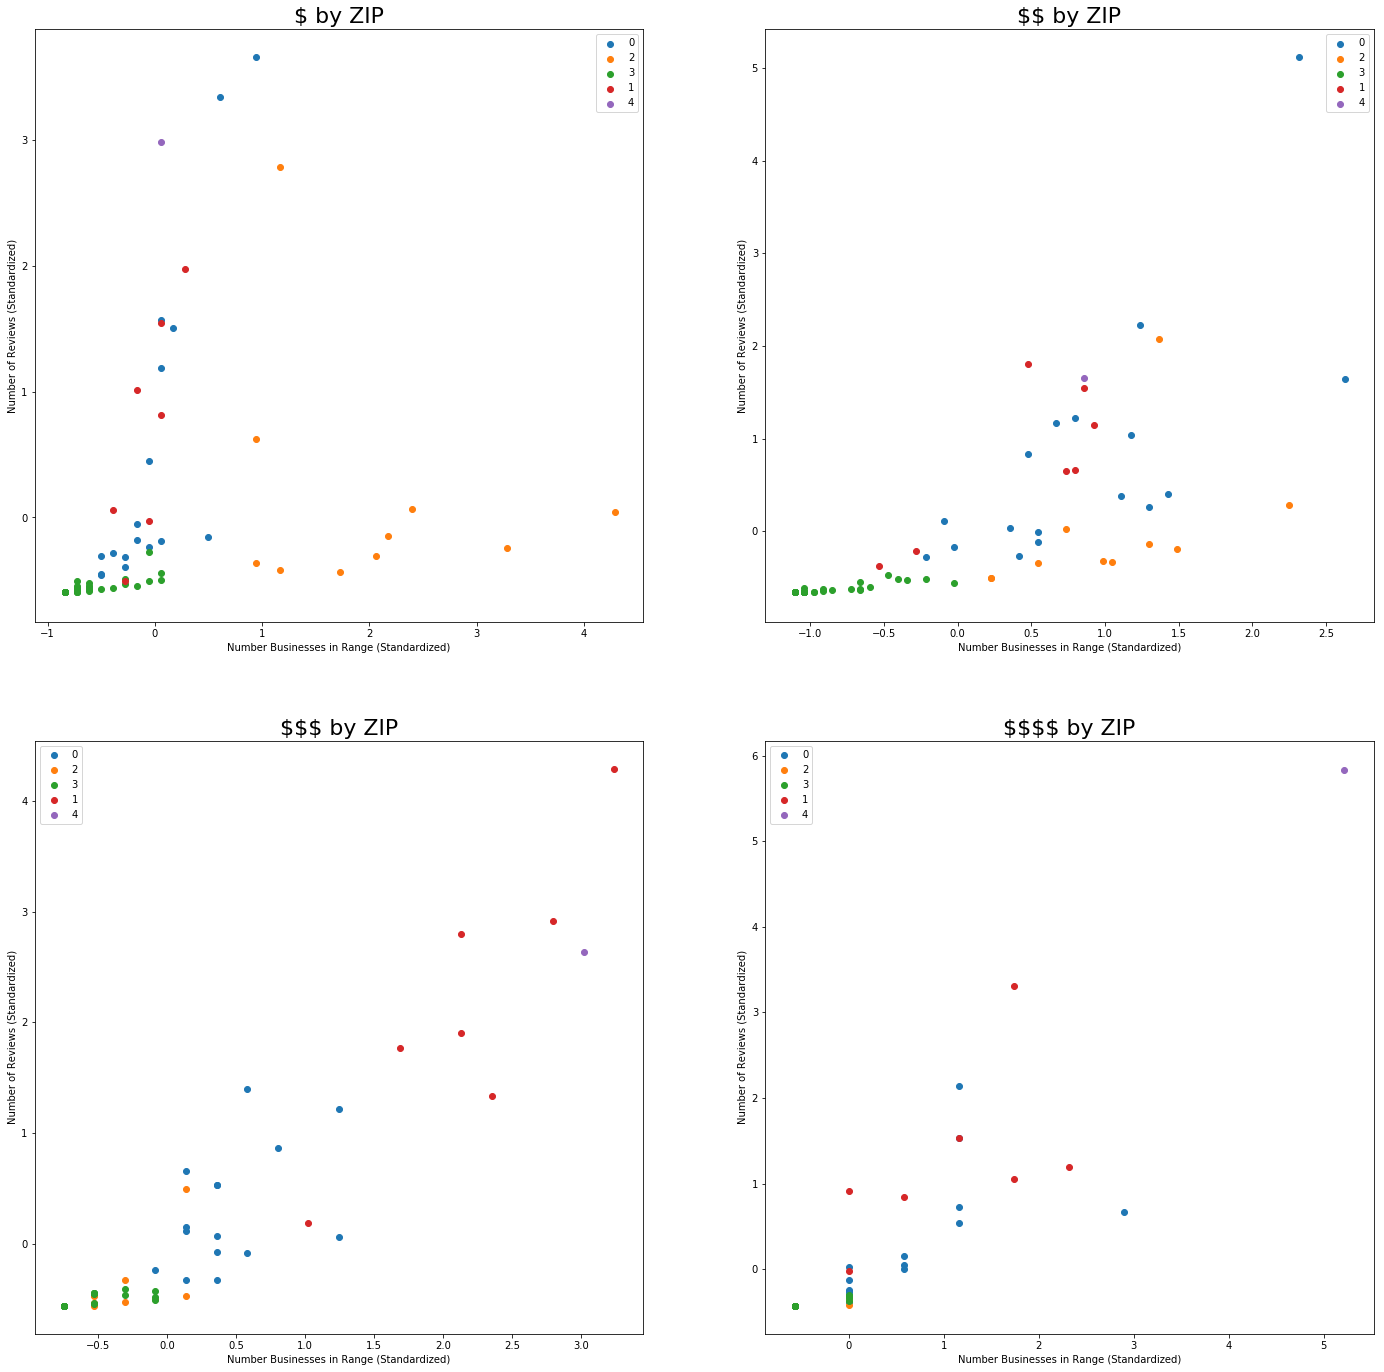

In [400]:
fig, ax = plt.subplots(2,2,figsize=(24,24),sharey=False)
ax = ax.ravel()

for i in data.ac_pred_1.unique():
    ax[0].scatter(data[data.ac_pred_1==i].pr_1s, data[data.ac_pred_1==i].rv_1s, label=str(i))
    ax[1].scatter(data[data.ac_pred_1==i].pr_2s, data[data.ac_pred_1==i].rv_2s, label=str(i))
    ax[2].scatter(data[data.ac_pred_1==i].pr_3s, data[data.ac_pred_1==i].rv_3s, label=str(i))
    ax[3].scatter(data[data.ac_pred_1==i].pr_4s, data[data.ac_pred_1==i].rv_4s, label=str(i))

#ax[0].scatter(data.pr_1, data.rv_1)
ax[0].set_title('\$ by ZIP', fontsize=22)
ax[0].set_xlabel('Number Businesses in Range (Standardized)')
ax[0].set_ylabel('Number of Reviews (Standardized)')
ax[0].legend()

#ax[1].scatter(data.pr_2, data.rv_2)
ax[1].set_title('\$$ by ZIP', fontsize=22)
ax[1].set_xlabel('Number Businesses in Range (Standardized)')
ax[1].set_ylabel('Number of Reviews (Standardized)')
ax[1].legend()

#ax[2].scatter(data.pr_3, data.rv_3)
ax[2].set_title('\$\$$ by ZIP', fontsize=22)
ax[2].set_xlabel('Number Businesses in Range (Standardized)')
ax[2].set_ylabel('Number of Reviews (Standardized)')
ax[2].legend()

#ax[3].scatter(data.pr_3, data.rv_3)
ax[3].set_title('\$\$\$$ by ZIP', fontsize=22)
ax[3].set_xlabel('Number Businesses in Range (Standardized)')
ax[3].set_ylabel('Number of Reviews (Standardized)')
ax[3].legend()

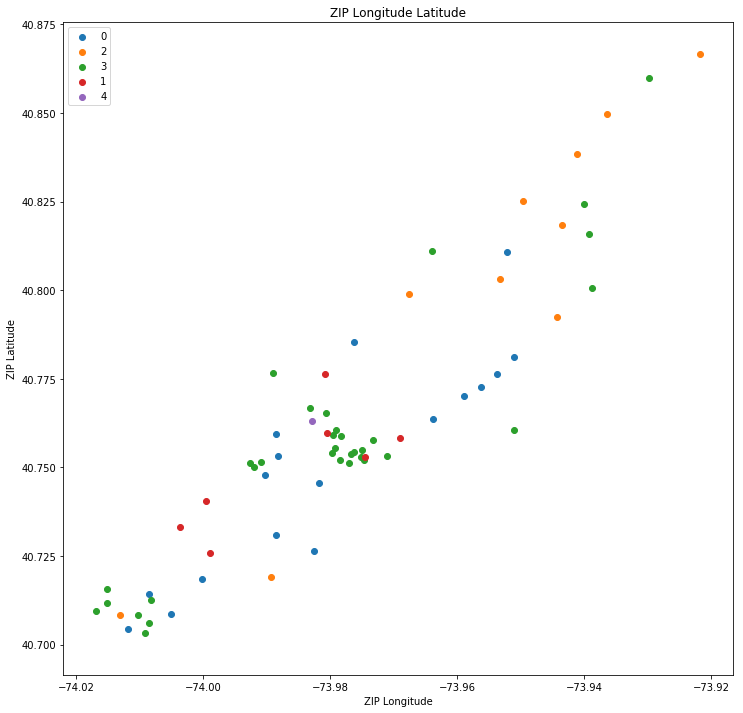

In [401]:
plt.figure(figsize=(12,12))
for i in data.ac_pred_1.unique():
    plt.scatter(data[data.ac_pred_1==i].avg_long, data[data.ac_pred_1==i].avg_lat, label=str(i))

plt.title('ZIP Longitude Latitude')
plt.xlabel('ZIP Longitude')
plt.ylabel('ZIP Latitude')
plt.legend()